In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

%matplotlib inline


In [2]:
df = pd.read_csv("titanic_train.csv")

target = "Survived"
numeric = ["Age", "SibSp", "Parch", "Fare"]
categorical = ["Pclass", "Sex", "Embarked"]

X = df[numeric + categorical]
y = df[target]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric),
    ("cat", categorical_transformer, categorical)
])


In [4]:
from sklearn.tree import DecisionTreeClassifier

tree_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42))
])

In [5]:
param_grid = {
    "model__max_depth": [None, 3, 5, 7, 9, 12, 15],
    "model__min_samples_split": [2, 5, 10, 20],
    "model__min_samples_leaf": [1, 2, 5, 10]
}

In [6]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=tree_pipeline,
    param_grid=param_grid,
    scoring="f1",   # F1 helps when classes are imbalanced
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [None, 3, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [7]:
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best parameters: {'model__max_depth': 7, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}
Best CV score: 0.7517991316675527


In [8]:
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_valid)

acc = accuracy_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)

print("Accuracy:", acc)
print("F1 Score:", f1)

Accuracy: 0.7932960893854749
F1 Score: 0.7086614173228346


In [9]:
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=300, random_state=42))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_valid)

acc_rf = accuracy_score(y_valid, y_pred_rf)
f1_rf = f1_score(y_valid, y_pred_rf)

In [10]:
metrics = pd.DataFrame([
    {"Model": "DecisionTree (best)", "Accuracy": acc, "F1": f1},
    {"Model": "RandomForest", "Accuracy": acc_rf, "F1": f1_rf}
])
metrics

,Model,Accuracy,F1
0,DecisionTree (best),0.793296,0.708661
1,RandomForest,0.821229,0.750000


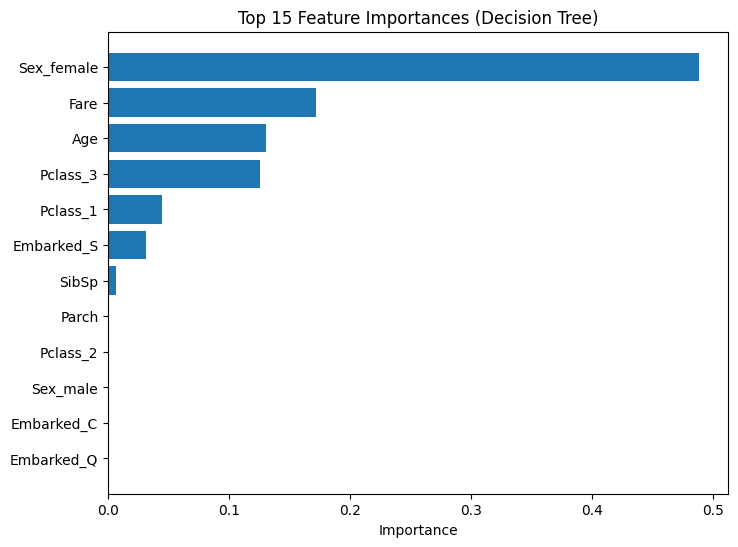

In [11]:
encoder = best_tree.named_steps["preprocessor"].named_transformers_["cat"].named_steps["encoder"]
feature_names = numeric + list(encoder.get_feature_names_out(categorical))

importances = best_tree.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(feat_imp["Feature"].head(15)[::-1], feat_imp["Importance"].head(15)[::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (Decision Tree)")
plt.show()